## Compute the features from all layers and check.

1. https://keras.io/api/applications/#vgg19
2. Make the computation a bit modular.
3. Plot the TCAV scores with features from all layers.

### Layers in VGG19

1. Conv3x3 (64), Conv3x3 (64), MaxPool
2. Conv3x3 (128), Conv3x3 (128), MaxPool
3. Conv3x3 (256), Conv3x3 (256), Conv3x3 (256), Conv3x3 (256), MaxPool
4. Conv3x3 (512), Conv3x3 (512), Conv3x3 (512), Conv3x3 (512), MaxPool
5. Conv3x3 (512), Conv3x3 (512), Conv3x3 (512), Conv3x3 (512), MaxPool
6. FC + Softmax (we remove this, since include_top = False)

In [135]:
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import concurrent.futures
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class ModelInstantiate:
    def __init__(self, layer, mode):
        self.layer = layer
        self.mode = mode
        
    def get_model(self):
        if self.mode == 'VGG19':
            base_model = VGG19(weights='imagenet', include_top=False)
        else:
            base_model = VGG16(weights='imagenet', include_top=False)
        model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer).output)
        return model
    
    def _get_features(self, img):
        model = self.get_model()
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        fts = model.predict(img_data)
        fts_np = np.array(fts)
        return np.squeeze(fts_np)

In [3]:
class ImageReader:
    def __init__(self, classes, folderpath, label_dict):
        self.classes = classes
        self.folderpath = folderpath
        self.label_dict = label_dict
        self.images = []
        self.labels = []
        
    def read_images(self):
        for base in self.classes:
            for ix, imgp in tqdm(enumerate(glob(self.folderpath + base + '/*.jpg'))):
                label = imgp.split('/')[-2]
                img = cv2.imread(imgp)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224,224))
                self.images.append(img)
                self.labels.append(self.label_dict[label])
    
    def get_images_and_labels(self):
        self.read_images()
        return self.images, self.labels

In [141]:
#layers = ["block1_pool", "block2_pool", "block3_pool", "block4_pool", "block5_pool"]
layers = ["block1_pool", "block2_pool", "block3_pool"]
modes = ["VGG16", "VGG19"]
classes = ["zebra", "tiger"]
classes_dict = {"zebra": 1, "tiger": 0}
concepts = ["zebra_stripes", "tiger_stripes"]
concepts_dict = {"zebra_stripes": 1, "tiger_stripes": 0}
folderpath = "/Users/Janjua/Desktop/QCRI/Work/zebra_stripes_data/"

reader_base = ImageReader(classes, folderpath, classes_dict)
reader_concept = ImageReader(concepts, folderpath, concepts_dict)

In [142]:
concept_imgs, concept_labels = reader_concept.get_images_and_labels()

79it [00:00, 912.46it/s]
79it [00:00, 838.82it/s]


In [143]:
print('Reading data for both - Zebra and Tiger!')
zebra_reader_base = ImageReader([classes[0]], folderpath, classes_dict)
tiger_reader_base = ImageReader([classes[1]], folderpath, classes_dict)

zebra_imgs, zebra_labels = zebra_reader_base.get_images_and_labels()
tiger_imgs, tiger_labels = tiger_reader_base.get_images_and_labels()

79it [00:00, 861.80it/s]
79it [00:00, 931.77it/s]

Reading data for both - Zebra and Tiger!


In [144]:
print(len(concept_imgs), len(zebra_imgs), len(concept_labels))
print(len(tiger_imgs))

158 79 158
79


In [ ]:
concept_fts_dict_VGG16 = {
                    "block1_pool": [],
                    "block2_pool": [],
                    "block3_pool": [],
                    "block4_pool": [],
                    "block5_pool": [],
                    "block1_conv1": [],
                    "block2_conv1": [],
                    "block1_conv2": [],
                    "block2_conv2": [],
                    "block3_conv1": [],
                    "block4_conv1": [],
                    "block3_conv2": [],
                    "block4_conv2": [],
                    "block5_conv2": [],
                    "block5_conv3": []
                 }

zebra_fts_dict_VGG16 = {
                    "block1_pool": [],
                    "block2_pool": [],
                    "block3_pool": [],
                    "block4_pool": [],
                    "block5_pool": [],
                    "block1_conv1": [],
                    "block2_conv1": [],
                    "block1_conv2": [],
                    "block2_conv2": [],
                    "block3_conv1": [],
                    "block4_conv1": [],
                    "block3_conv2": [],
                    "block4_conv2": [],
                    "block5_conv2": [],
                    "block5_conv3": []
                 }

print('Go get coffee - this takes some time.')

with concurrent.futures.ProcessPoolExecutor() as executor:    
    for layer in layers:
        model_instance =  ModelInstantiate(layer, modes[0])
        print('Running for layer # ', layer)

        for ix, val in tqdm(enumerate(concept_imgs)):
            fts_1 = executor.submit(model_instance._get_features, val)
            concept_fts_dict_VGG16[layer].append(fts_1.result())

        for ix, val in tqdm(enumerate(zebra_imgs)):
            fts_2 = executor.submit(model_instance._get_features, val)
            zebra_fts_dict_VGG16[layer].append(fts_2.result()) 

0it [00:00, ?it/s]

Go get coffee - this takes some time.
Running for layer #  block1_pool
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


1it [00:00,  1.30it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2it [00:01,  1.33it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


3it [00:02,  1.35it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


4it [00:02,  1.36it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


5it [00:03,  1.38it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


6it [00:04,  1.39it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


7it [00:05,  1.39it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


158it [03:10,  1.21s/it]
9it [00:16,  1.82s/it]

In [ ]:
no_concepts = 158
no_imgs = 79
lbls_np = np.array(concept_labels)
#clf = LogisticRegression(random_state=0)
#clf = ElasticNet(random_state=0)
clf = LinearSVC(random_state=0, tol=1e-5)
concept_cavs = {
                    "block1_pool": [],
                    "block2_pool": [],
                    "block3_pool": [],
                    "block4_pool": [],
                    "block5_pool": [],
                    "block1_conv1": [],
                    "block2_conv1": [],
                    "block1_conv2": [],
                    "block2_conv2": [],
                    "block3_conv1": [],
                    "block4_conv1": [],
                    "block3_conv2": [],
                    "block4_conv2": [],
                    "block5_conv2": [],
                    "block5_conv3": []
                 }

for key, value in concept_fts_dict_VGG16.items():
    if len(value) > 0:
        print("For layer # - ", key)
        fts_np = np.array(value)
        fts_np = fts_np.reshape(no_concepts, -1)
        clf.fit(fts_np, lbls_np)
        # compute CAVs
        if len(clf.coef_) == 1:
            cavs = [-1 * clf.coef_[0], clf.coef_[0]]
        else:
            cavs = [c for c in clf.coef_]
        concept_cavs[key].append(cavs)

In [ ]:
# since we have CAVs all computed, now we have to compute TCAV.
def get_direction(layer, concept):
    cavs = concept_cavs[layer][0] # since it is a list of lists
    return cavs[concepts.index(concept)]

def compute_direc_derivative(x, y):
    a = np.dot(x, y)
    return a < 0

In [ ]:
# for each base image (zebra) feature, compute the directional derivative and get the TCAV score.

tcavs = {}
for key, value in zebra_fts_dict_VGG16.items():
    if len(value):
        count = 0
        value = np.array(value)
        value = value.reshape(no_imgs, -1)
        cav = get_direction(key, 'zebra_stripes')
        print("For layer # - ", key)
        for ft in value: # loop over every feature
            dydx = compute_direc_derivative(ft, cav)
            if dydx.any(): count += 1
        tcav = float(count) / float(len(value))
        tcavs[key] = tcav

In [ ]:
print('Printing TCAV scores for each block!')
print(tcavs)

In [ ]:
# Plot the TCAV scores
x_points = [x for x in range(len(tcavs.keys()))]
keys = list(tcavs.keys())
plt.bar(x_points, tcavs.values(), width=0.1, color='k')
plt.xticks(x_points, tcavs.keys())
plt.title('TCAV Scores for Pool Layers')
plt.ylabel('TCAV Score')
plt.show()

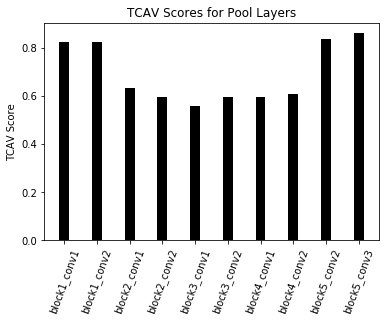

In [113]:
plot_scores = {
    "block1_conv1": 0.8227848101265823, 
    "block1_conv2": 0.8227848101265823, 
    "block2_conv1": 0.6329113924050633,
    "block2_conv2": 0.5949367088607594,
    "block3_conv1": 0.5569620253164557, 
    "block3_conv2": 0.5949367088607594,
    "block4_conv1": 0.5949367088607594,
    "block4_conv2": 0.6075949367088608,
    "block5_conv2": 0.8354430379746836,
    "LSVC_block5_conv2": 0.8354430379746836,
    "block5_conv3": 0.8607594936708861,
    "LSVC_block5_conv3": 0.8734177215189873
}


x_points = [x for x in range(len(plot_scores.keys()))]
keys = list(plot_scores.keys())
plt.bar(x_points, plot_scores.values(), width=0.3, color='k')
plt.xticks(x_points, plot_scores.keys(), rotation=70)
plt.title('TCAV Scores for Pool Layers')
plt.ylabel('TCAV Score')
plt.show()